In [84]:
import numpy as np 
import matplotlib.pyplot as plt
import math
from scipy.fft import fft2, ifft2, fftshift
import time
from time import strftime, gmtime
import numba
from numba import jit
import pandas as pd
import sys

import concurrent.futures
import multiprocessing
num_processes = multiprocessing.cpu_count()

from timeit import default_timer as timer

import sympy
import os
font = {'family': 'serif',
          'color':  'black',
          'weight': 'normal',
          'size': 16,
          }

In [160]:
global first_term, second_term, third_term, V_ph, V_ph_k, rho, dt, U, dl

N = 1024
L = 60

#del r_discretization, k_discretization
l = np.linspace(-L/2,L/2,N)
k = np.linspace(0,2*np.pi/L,N)
dl = np.abs(l[1]-l[0])
dx = dl
dy = dx
dkx = np.abs(k[1]-k[0])
dky = dkx
X, Y = np.meshgrid(l,l)

mu2_p = np.zeros((N,N))
lambda2_q = np.zeros((N,N))

p = 2 * np.pi / L
for i in range(0,N):
  for j in range(0,N//2):
    mu2_p[i,j] = pow(j * p, 2)
  for j in range(N//2,N):    
    mu2_p[i,j] = pow((j - N) * p, 2)

for j in range(0,N):     
  for i in range(0,N//2):    
    lambda2_q[i,j] = pow(i * p, 2);    
  for i in range(N//2,N):    
    lambda2_q[i,j] = pow((i - N) * p, 2)
    
K2 = mu2_p+lambda2_q
Kx, Ky = np.meshgrid(k,k)
Kx2 = Kx * Kx
Ky2 = Ky * Ky
K2 = Kx2 + Ky2
K = np.sqrt(K2)

g = np.ones((N,N), dtype=np.float32)
S = np.ones((N,N), dtype=np.float32)

#Initializing the terms
first_term = np.zeros((N,N), dtype=np.complex64)
second_term = np.zeros((N,N), dtype=np.complex64)
third_term = np.zeros((N,N), dtype=np.complex64)

V_ph = np.zeros((N,N), dtype=np.complex64) 
V_ph_k = np.zeros((N,N), dtype=np.complex64)

@numba.jit(nopython=True, parallel=True)
def calculate_second_term(g):
  #Calculating the second gradient of |sqrt(g(r))|^2
  grad_x = np.zeros((N,N), dtype=np.complex64)
  grad_y = np.zeros((N,N), dtype=np.complex64)

  for i in range(0,N):
    for j in range(0,N-1):
        grad_x[i,j] = g[i,j] - g[i,j+1]
    grad_x[i,N-1] = grad_x[i,N-2] 

  for j in range(0,N):
    for i in range(0,N-1):
        grad_y[i,j] = g[i,j] - g[i+1,j]
    grad_y[N-1,j] = grad_y[N-2,j]  

  aux = (grad_x*grad_x+grad_y*grad_y) / (dl * dl)
  gradient_root_g = aux / (4.0*g)

  return gradient_root_g

In [161]:
U = 10
rho = 1

v = U*np.exp(-X*X-Y*Y)
c1 = pow(2*np.pi,-2) / rho

g = np.ones((N,N), dtype=np.float32)
S = np.ones((N,N), dtype=np.float32)
aux = np.zeros((N,N))

dt = 0.1
condition = True
counter = 1
while condition:
  omega_k = -0.25*K2*(2*S+1)*(1-(1/S))*(1-(1/S)) 
  omega = dkx * dky * (ifft2(omega_k, workers=10, norm='forward')) * c1
  second_term = calculate_second_term(g)
  V_ph = g*v+1*second_term+(g-1)*omega
  V_ph_k = fftshift(rho * (fft2(V_ph, workers=10, norm='backward')) * dx * dy)
  aux = np.real(K2+4*V_ph_k)
  #if any(np.less_equal(aux, 0)):
   # print("instability at rho = ", rho)
    #break
  new_S = K / np.sqrt(np.abs(aux)) 
  S = (1-dt)*S + dt*new_S
  dg = np.real(1+(dkx * dky * ifft2(S-1, workers=10, norm='forward')) * c1)
  new_g = dg#g*np.exp(dt*(dg-g))
  if counter%25==0 or counter==1:
    error = np.abs(np.sum(np.sum(g-new_g))) * dl * dl / dt
    condition = error > 1e-6
    print('i = {}, error = {}'.format(counter, error))
    
  g = new_g
  
  counter = counter + 1

i = 1, error = 9.574089457313548e-07


(0.0, 40.0)

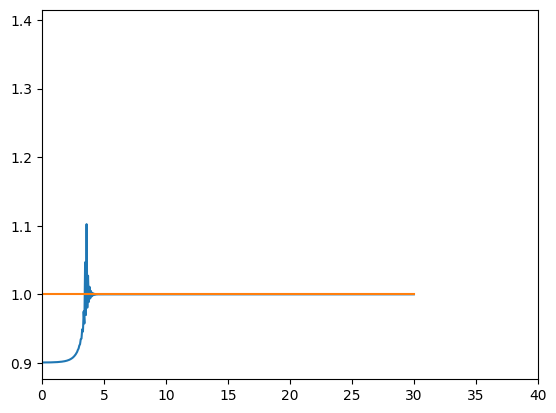

In [162]:
plt.plot(l,np.real((S[:,N//2])))
plt.plot(l,np.real((g[:,N//2])))

#plt.xlim(np.min(l),np.max(l))
plt.xlim(0,40)

In [13]:
l[0]-l[1]

-0.019540791402050672

In [59]:
np.max(S)

66.55514500346469

In [66]:
np.min(np.min(S))

0.0003699884752337802

In [145]:
Kx2

array([[0.00000000e+00, 6.07126761e-04, 2.42850704e-03, ...,
        3.88615768e+01, 3.91693901e+01, 3.94784176e+01],
       [0.00000000e+00, 6.07126761e-04, 2.42850704e-03, ...,
        3.88615768e+01, 3.91693901e+01, 3.94784176e+01],
       [0.00000000e+00, 6.07126761e-04, 2.42850704e-03, ...,
        3.88615768e+01, 3.91693901e+01, 3.94784176e+01],
       ...,
       [0.00000000e+00, 6.07126761e-04, 2.42850704e-03, ...,
        3.88615768e+01, 3.91693901e+01, 3.94784176e+01],
       [0.00000000e+00, 6.07126761e-04, 2.42850704e-03, ...,
        3.88615768e+01, 3.91693901e+01, 3.94784176e+01],
       [0.00000000e+00, 6.07126761e-04, 2.42850704e-03, ...,
        3.88615768e+01, 3.91693901e+01, 3.94784176e+01]])